In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from pathlib import Path
import ontology.Schema as sc
import qai.QAI_Manager as q
import pickle
import os
from nlp.NLP_Processor import NLP_Processor
from classifier.ML_Classifier import ML_Classifier
from nlp.NER_Trainer import NER_Trainer 
from datetime import datetime
import spacy
import nlp.Solr_Connection as solr_connection
import pandas as pd

from config import *  #Change configurations in file "config.py"


%matplotlib inline


In [2]:
def train_QAIs():  
    schema = sc.getGraph(ontology_path)
    classes_index = sc.load_classes_index(schema)
    properties_index = sc.load_properties_index(schema)
    schema.close()
    QAI_Manager = q.QAI_Manager(QAIs_path,properties_index)
    ner_trainer = NER_Trainer(QAI_Manager.QAIs,classes_index,sparql_endpoint,graph_name,solr_host,solr_port,solr_core)
    ner_trainer.make_train_dataset(savePath=path_train_NER_temp)
    return QAI_Manager

In [3]:
def pre_process_classifier(QAI_Manager,use_semantic_features = True,number_qp_samples = 0):
    labels_path = os.path.join(path_train_NER_temp,"labels.sav")
    with open(labels_path,"rb") as file:
        labels_NER = pickle.load(file)
    nlp_processor = NLP_Processor(labels_NER,nlp_model_load,startup_solr=False)
    QAI_Manager.compute_SVs(nlp_processor)
    X,y = ML_Classifier.pre_process_data(QAI_Manager.QAIs,nlp_processor,use_semantic_features,number_qp_samples)
    return X,y


In [4]:
def train_classifier(X,y,model = None):
    classifier = ML_Classifier(model_path="persistence/classifier",model_file="ml_classifier.sav",model = model)
    time = classifier.fit(X,y)
    return classifier,time

# Experiments without Semantic Features (Only Syntatic Features)

In [88]:
QAIs_path = "input/medibot/MediBot.json"
QAI_Manager = train_QAIs()
X,y = pre_process_classifier(QAI_Manager,use_semantic_features = False,number_qp_samples = 0)


Creating train dataset
Created train dataset
Using semantic features False. QPs limited False


In [89]:
results = []

In [90]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.057432


Score evaluations using cross validation with cv = 5:
Precision = 0.7725
Recall = 0.7125
F-1 Score = 0.705952380952381


In [91]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.014469


Score evaluations using cross validation with cv = 5:
Precision = 0.6066666666666667
Recall = 0.6
F-1 Score = 0.5654761904761905


In [92]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',n_jobs=-1)

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.989635


Score evaluations using cross validation with cv = 5:
Precision = 0.8
Recall = 0.7875
F-1 Score = 0.7641666666666668


In [93]:
from sklearn.svm import SVC
model = SVC(gamma='auto')

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" auto",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.014825


Score evaluations using cross validation with cv = 5:
Precision = 0.5391666666666666
Recall = 0.575
F-1 Score = 0.5201190476190476


In [94]:
from sklearn.svm import SVC
model = SVC(C=1, kernel="linear")


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" linear",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.010279


Score evaluations using cross validation with cv = 5:
Precision = 0.9166666666666666
Recall = 0.875
F-1 Score = 0.8700000000000001


In [95]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=0)

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.006410


Score evaluations using cross validation with cv = 5:
Precision = 0.5458333333333333
Recall = 0.575
F-1 Score = 0.5341666666666666


In [96]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.019754


Score evaluations using cross validation with cv = 5:
Precision = 0.6354166666666665
Recall = 0.7
F-1 Score = 0.625


In [97]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
model = NearestCentroid()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.004696


Score evaluations using cross validation with cv = 5:
Precision = 0.63125
Recall = 0.625
F-1 Score = 0.5916666666666666


In [98]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" 1 layer",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.302083


Score evaluations using cross validation with cv = 5:
Precision = 0.9208333333333332
Recall = 0.9
F-1 Score = 0.8816666666666666


In [99]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100,100))

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" 2 layers",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.177650


Score evaluations using cross validation with cv = 5:
Precision = 0.9458333333333332
Recall = 0.8875
F-1 Score = 0.9066666666666666


In [100]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.074769


Score evaluations using cross validation with cv = 5:
Precision = 0.17202380952380952
Recall = 0.2875
F-1 Score = 0.17477124183006537


In [101]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
model = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100),n_estimators=100,learning_rate=0.5)

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" (RandomForest)",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.081407


Score evaluations using cross validation with cv = 5:
Precision = 0.7541666666666665
Recall = 0.8125
F-1 Score = 0.7700000000000001


In [102]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.004144


Score evaluations using cross validation with cv = 5:
Precision = 0.44875
Recall = 0.475
F-1 Score = 0.41869047619047617


In [103]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append(['Nearest Neighbor',p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.003910


Score evaluations using cross validation with cv = 5:
Precision = 0.7079166666666666
Recall = 0.675
F-1 Score = 0.6576190476190475


In [104]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model = QuadraticDiscriminantAnalysis()


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.007172


Score evaluations using cross validation with cv = 5:
Precision = 0.41380952380952374
Recall = 0.4375
F-1 Score = 0.3878968253968254


In [105]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  VotingClassifier
gaussian = GaussianNB()
linear = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',n_jobs=-1)

model = VotingClassifier(estimators=[('gaus', gaussian), ('line', linear)],voting='soft',n_jobs=-1)


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append(["Soft "+type(clf.model).__name__+" (GaussianNB + LogisticRegression)",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.137478


Score evaluations using cross validation with cv = 5:
Precision = 0.7725
Recall = 0.7125
F-1 Score = 0.705952380952381


In [106]:
evaluations = pd.DataFrame(results,columns=['Classifier','Precision','Recall','F1','Time'])
top = evaluations.sort_values(['F1','Time'],ascending=[False,True])
top.to_csv("evaluations_syntatic.csv", encoding='utf-8', index=False)
top
# evaluations.to_csv("evaluations_syntatic.csv", encoding='utf-8', index=False)
# evaluations

,Classifier,Precision,Recall,F1,Time
9,MLPClassifier 2 layers,0.945833,0.8875,0.906667,00:00:00.177650
8,MLPClassifier 1 layer,0.920833,0.9000,0.881667,00:00:00.302083
4,SVC linear,0.916667,0.8750,0.870000,00:00:00.010279
11,AdaBoostClassifier (RandomForest),0.754167,0.8125,0.770000,00:00:00.081407
2,LogisticRegression,0.800000,0.7875,0.764167,00:00:00.989635
0,GaussianNB,0.772500,0.7125,0.705952,00:00:00.057432
15,Soft VotingClassifier (GaussianNB + LogisticRe...,0.772500,0.7125,0.705952,00:00:00.137478
13,Nearest Neighbor,0.707917,0.6750,0.657619,00:00:00.003910
6,RandomForestClassifier,0.635417,0.7000,0.625000,00:00:00.019754
7,NearestCentroid,0.631250,0.6250,0.591667,00:00:00.004696


# Experiments using Semantic Features

In [38]:
QAIs_path = "input/medibot/MediBot.json"
QAI_Manager = train_QAIs()
X,y = pre_process_classifier(QAI_Manager,use_semantic_features = True,number_qp_samples = 0)


Creating train dataset
Created train dataset
Using semantic features True. QPs limited False


In [39]:
results = []

In [40]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.005808


Score evaluations using cross validation with cv = 5:
Precision = 0.9833333333333332
Recall = 0.975
F-1 Score = 0.9733333333333334


In [110]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.004965


Score evaluations using cross validation with cv = 5:
Precision = 0.6641666666666666
Recall = 0.6875
F-1 Score = 0.6451190476190476


In [111]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',n_jobs=-1)

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.039211


Score evaluations using cross validation with cv = 5:
Precision = 0.9583333333333333
Recall = 0.9375
F-1 Score = 0.9333333333333333


In [112]:
from sklearn.svm import SVC
model = SVC(gamma='auto')

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" auto",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.005297


Score evaluations using cross validation with cv = 5:
Precision = 0.7491666666666666
Recall = 0.775
F-1 Score = 0.7319047619047618


In [113]:
from sklearn.svm import SVC
model = SVC(C=1, kernel="linear")


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" linear",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.006388


Score evaluations using cross validation with cv = 5:
Precision = 0.9833333333333332
Recall = 0.975
F-1 Score = 0.9733333333333334


In [114]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=0)

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.120612


Score evaluations using cross validation with cv = 5:
Precision = 0.8583333333333332
Recall = 0.875
F-1 Score = 0.8608333333333332


In [115]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.015814


Score evaluations using cross validation with cv = 5:
Precision = 0.7370833333333333
Recall = 0.7
F-1 Score = 0.7030952380952382


In [116]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
model = NearestCentroid()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.043969


Score evaluations using cross validation with cv = 5:
Precision = 0.8558333333333332
Recall = 0.8375
F-1 Score = 0.8226190476190476


In [117]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" 1 layer",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:03.552941


Score evaluations using cross validation with cv = 5:
Precision = 0.9666666666666666
Recall = 0.9625
F-1 Score = 0.96


In [118]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100,100))

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" 2 layers",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.206763


Score evaluations using cross validation with cv = 5:
Precision = 0.9666666666666666
Recall = 0.9625
F-1 Score = 0.9600000000000002


In [119]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:01.652253


Score evaluations using cross validation with cv = 5:
Precision = 0.2966666666666667
Recall = 0.45
F-1 Score = 0.3704761904761905


In [120]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
model = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100),n_estimators=100,learning_rate=0.5)

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" (RandomForest)",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.093485


Score evaluations using cross validation with cv = 5:
Precision = 0.8916666666666666
Recall = 0.925
F-1 Score = 0.8883333333333334


In [121]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.074481


Score evaluations using cross validation with cv = 5:
Precision = 0.7929166666666667
Recall = 0.775
F-1 Score = 0.7577380952380952


In [122]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append(['Nearest Neighbor',p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.004147


Score evaluations using cross validation with cv = 5:
Precision = 0.8791666666666667
Recall = 0.875
F-1 Score = 0.86


In [123]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model = QuadraticDiscriminantAnalysis()


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.004595


Score evaluations using cross validation with cv = 5:
Precision = 0.41380952380952374
Recall = 0.4375
F-1 Score = 0.3878968253968254


In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  VotingClassifier
gaussian = GaussianNB()
linear = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',n_jobs=-1)

model = VotingClassifier(estimators=[('gaus', gaussian), ('line', linear)],voting='soft',n_jobs=-1)


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append(["Soft "+type(clf.model).__name__+" (GaussianNB + LogisticRegression)",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.941955


Score evaluations using cross validation with cv = 5:
Precision = 0.9833333333333332
Recall = 0.975
F-1 Score = 0.9733333333333334


In [125]:
evaluations = pd.DataFrame(results,columns=['Classifier','Precision','Recall','F1','Time'])
top = evaluations.sort_values(['F1','Time'],ascending=[False,True])
top.to_csv("evaluations_semantic.csv", encoding='utf-8', index=False)
top
# evaluations.to_csv("evaluations_semantic.csv", encoding='utf-8', index=False)
# evaluations

,Classifier,Precision,Recall,F1,Time
0,GaussianNB,0.983333,0.9750,0.973333,00:00:00.004159
4,SVC linear,0.983333,0.9750,0.973333,00:00:00.006388
15,Soft VotingClassifier (GaussianNB + LogisticRe...,0.983333,0.9750,0.973333,00:00:00.112663
9,MLPClassifier 2 layers,0.966667,0.9625,0.960000,00:00:00.206763
8,MLPClassifier 1 layer,0.966667,0.9625,0.960000,00:00:03.552941
2,LogisticRegression,0.958333,0.9375,0.933333,00:00:00.039211
11,AdaBoostClassifier (RandomForest),0.891667,0.9250,0.888333,00:00:00.093485
5,DecisionTreeClassifier,0.858333,0.8750,0.860833,00:00:00.120612
13,Nearest Neighbor,0.879167,0.8750,0.860000,00:00:00.004147
7,NearestCentroid,0.855833,0.8375,0.822619,00:00:00.043969



# Evaluating the impact of the number of QPs in classification

## Using Semantic Features

In [126]:
results = []

In [127]:
from sklearn.naive_bayes import GaussianNB
for number_qps in range(2,11):
    model = GaussianNB()
    
    X,y = pre_process_classifier(QAI_Manager,use_semantic_features = True,number_qp_samples = number_qps)
    clf,t = train_classifier(X,y,model = model)
    cv=5
    if number_qps < 5:
        cv = max((number_qps - 1),2)
    p,r,f = clf.eval_model(X,y,cv=cv)
    results.append([number_qps,p,r,f,t])

Using semantic features True. QPs limited True
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Using customized model
Training classifier done! Elapsed time: 0:00:00.005624


Score evaluations using cross validation with cv = 2:
Precision = 0.47916666666666663
Recall = 0.625
F-1 Score = 0.5208333333333333
Using semantic features True. QPs limited True
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Using customized model
Training classifier done! Elapsed time: 0:00:00.003754


Score evaluations using cross validation with cv = 2:
Precision = 0.71875
Recall = 0.75
F-1 Score = 0.7166666666666667
Using semantic features True. QPs limited True
Reached QPs limited  4
Reached QPs limited  4
Reached QPs limited  4
Reached QPs

In [128]:
evaluations = pd.DataFrame(results,columns=['Number_QPs','Precision','Recall','F1','Time'])
top = evaluations.sort_values(['F1','Time'],ascending=[False,True])
top.to_csv("evaluations_semantic_number_qp.csv", encoding='utf-8', index=False)
top

,Number_QPs,Precision,Recall,F1,Time
8,10,0.983333,0.975000,0.973333,00:00:00.005013
6,8,0.920833,0.925000,0.915000,00:00:00.004376
7,9,0.900000,0.912500,0.893333,00:00:00.005202
5,7,0.850000,0.887500,0.862500,00:00:00.075518
3,5,0.820833,0.875000,0.837500,00:00:00.004819
4,6,0.793333,0.837500,0.801786,00:00:00.063819
2,4,0.708333,0.770833,0.725000,00:00:00.004683
1,3,0.718750,0.750000,0.716667,00:00:00.003754
0,2,0.479167,0.625000,0.520833,00:00:00.005624


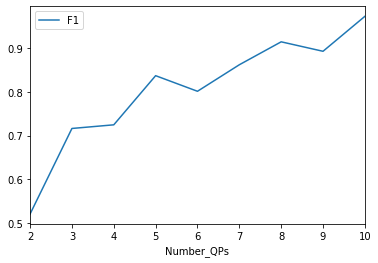

In [129]:
fig = evaluations.plot.line(x='Number_QPs',y='F1').get_figure()
fig.savefig("varing_qp.png")

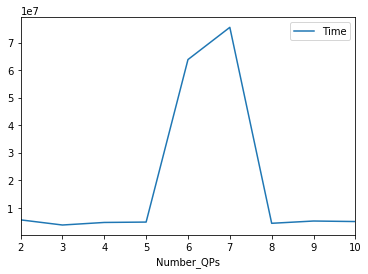

In [130]:
evaluations.plot.line(x='Number_QPs',y='Time')

## Without Semantic Features

In [131]:
results = []

In [132]:
from sklearn.neural_network import MLPClassifier
for number_qps in range(2,11):
    model = MLPClassifier(hidden_layer_sizes=(100,100))
    
    X,y = pre_process_classifier(QAI_Manager,use_semantic_features = False,number_qp_samples = number_qps)
    clf,t = train_classifier(X,y,model = model)
    cv=5
    if number_qps < 5:
        cv = max((number_qps - 1),2)
    p,r,f = clf.eval_model(X,y,cv=cv)
    results.append([number_qps,p,r,f,t])

Using semantic features False. QPs limited True
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Using customized model
Training classifier done! Elapsed time: 0:00:00.137013


Score evaluations using cross validation with cv = 2:
Precision = 0.38541666666666663
Recall = 0.5
F-1 Score = 0.5
Using semantic features False. QPs limited True
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Using customized model
Training classifier done! Elapsed time: 0:00:01.746361


Score evaluations using cross validation with cv = 2:
Precision = 0.45535714285714285
Recall = 0.5625
F-1 Score = 0.43660714285714286
Using semantic features False. QPs limited True
Reached QPs limited  4
Reached QPs limited  4
Reached QPs limited  4
Reached QP

In [133]:
evaluations = pd.DataFrame(results,columns=['Number_QPs','Precision','Recall','F1','Time'])
top = evaluations.sort_values(['F1','Time'],ascending=[False,True])
top.to_csv("evaluations_syntatic_number_qp.csv", encoding='utf-8', index=False)
top

,Number_QPs,Precision,Recall,F1,Time
8,10,0.937500,0.912500,0.906667,00:00:00.147355
7,9,0.900000,0.850000,0.844167,00:00:00.163608
6,8,0.904167,0.887500,0.823333,00:00:00.143859
4,6,0.620833,0.812500,0.799167,00:00:02.108101
5,7,0.733333,0.812500,0.790000,00:00:00.133543
3,5,0.608333,0.725000,0.558333,00:00:02.058356
0,2,0.385417,0.500000,0.500000,00:00:00.137013
2,4,0.473611,0.604167,0.491071,00:00:00.130458
1,3,0.455357,0.562500,0.436607,00:00:01.746361


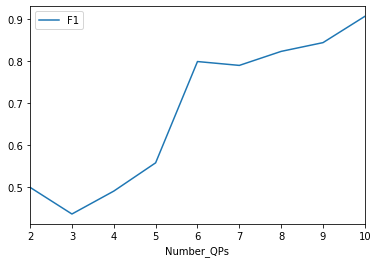

In [134]:
evaluations.plot.line(x='Number_QPs',y='F1')

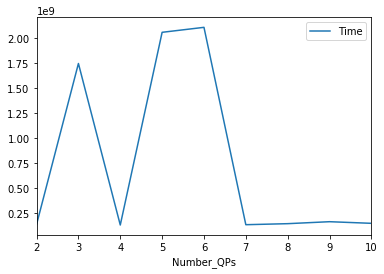

In [135]:
evaluations.plot.line(x='Number_QPs',y='Time')

# Test Model

In [23]:
#Create Train dataset
QAIs_path = "input/medibot/MediBot.json"
QAI_Manager = train_QAIs()
X,y = pre_process_classifier(QAI_Manager,use_semantic_features = True,number_qp_samples = 0)

QPs_training = []
for QAI in QAI_Manager.QAIs:
    for QP in QAI.QPs:
        QPs_training.append([QP,QAI.id])    
QPs_training = pd.DataFrame(QPs_training,columns=["pattern","class"])

Creating train dataset
Created train dataset
Using semantic features True. QPs limited False


In [24]:
#Create Test dataset
QAIs_path = "input/medibot/MediBot_Test_dataSet.json"
QAI_Manager = train_QAIs()
X_test,y_test = pre_process_classifier(QAI_Manager,use_semantic_features = True,number_qp_samples = 0)


QPs_test = []
for QAI in QAI_Manager.QAIs:
    for QP in QAI.QPs:
        QPs_test.append([QP,QAI.id])  
QPs_test = pd.DataFrame(QPs_test,columns=["pattern","class"])

Creating train dataset
Created train dataset
Using semantic features True. QPs limited False


In [25]:
#show datasets
print("Training:")
print(QPs_training)
print(X.shape)

print("Teste:\n")
print(QPs_test)
print(X_test.shape)

Training:
                                              pattern  class
0   quais medicamentos possuem o princípio ativo $...      0
1   o $qai_0_principioAtivo1 é o princípio ativo d...      0
2   indique medicamentos com a substancia $qai_0_p...      0
3    retorne remédio a base de $qai_0_principioAtivo1      0
4   quero saber o medicamentos com $qai_0_principi...      0
5   Quais medicamentos possuem a substância $qai_0...      0
6   retorne os medicamentos com princípios ativos ...      0
7   Busque os mdedicamentos com o $qai_0_principio...      0
8   Quais medicamentos possuem a substancia $qai_0...      0
9   Rertorne medicamentos que contenham a substanc...      0
10         quero saber a definção de $qai_1_termo_in2      1
11                   O que significa $qai_1_termo_in2      1
12                            defina $qai_1_termo_in2      1
13                        fale sobre $qai_1_termo_in2      1
14                me diga o que é um $qai_1_termo_in2      1
15            

In [26]:
#train_model
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

model = VotingClassifier(estimators=[('gaus', gaussian), ('line', linear)],voting='soft',n_jobs=-1)

clf,t = train_classifier(X,y,model = model)


Using customized model
Training classifier done! Elapsed time: 0:00:00.913596


In [27]:
#Predict labels
y_predicted = clf.predict(X_test)
print("true:\n",y_test.to_list())
print("predicted:\n",y_predicted)

true:
 [3, 3, 3, 5, 0, 2, 7, 5, 7, 1, 5, 1, 2, 6, 6, 1, 3, 4, 0, 6, 1, 2, 0, 5, 4, 0, 6, 7, 0, 7, 4, 6, 2, 4, 3, 4, 1, 2, 5, 7]
predicted:
 [3 3 3 5 0 2 7 5 7 1 5 1 2 6 6 1 3 4 0 6 1 2 0 5 4 0 6 7 0 7 4 6 2 3 3 4 1
 2 5 7]


In [28]:
#Testing model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

results = [(precision_score(y_test, y_predicted, average='weighted'), recall_score(y_test, y_predicted, average='weighted'),f1_score(y_test, y_predicted, average='weighted'))]
scores = pd.DataFrame(results,columns=['Precision','Recall','F1'])
scores


,Precision,Recall,F1
0,0.979167,0.975,0.974747


In [30]:
#Save results
training_path = "training_examples.csv"
QPs_training.to_csv(training_path, encoding='utf-8',index=False)
print("Training examples saved to: ",training_path)

test_path = "test_examples.csv"
QPs_test.to_csv(test_path, encoding='utf-8',index=False)
print("Test examples saved to: ",test_path)

result_path = "result_test.csv"
scores.to_csv(result_path, encoding='utf-8',index=False)
print("Test's results saved to: ",result_path)



Training examples saved to:  training_examples.csv
Test examples saved to:  test_examples.csv
Test's results saved to:  result_test.csv
